In [1]:
from datasets import load_dataset

dataset = load_dataset("clinc_oos", "small")  # "small" = 150 intents
train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["intent"]

validation_texts = dataset["validation"]["text"]
validation_labels = dataset["validation"]["intent"]

test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["intent"]


In [ ]:
# list all the intents with its label string
intents = dataset["train"].features["intent"].names 
intents

['restaurant_reviews',
 'nutrition_info',
 'account_blocked',
 'oil_change_how',
 'time',
 'weather',
 'redeem_rewards',
 'interest_rate',
 'gas_type',
 'accept_reservations',
 'smart_home',
 'user_name',
 'report_lost_card',
 'repeat',
 'whisper_mode',
 'what_are_your_hobbies',
 'order',
 'jump_start',
 'schedule_meeting',
 'meeting_schedule',
 'freeze_account',
 'what_song',
 'meaning_of_life',
 'restaurant_reservation',
 'traffic',
 'make_call',
 'text',
 'bill_balance',
 'improve_credit_score',
 'change_language',
 'no',
 'measurement_conversion',
 'timer',
 'flip_coin',
 'do_you_have_pets',
 'balance',
 'tell_joke',
 'last_maintenance',
 'exchange_rate',
 'uber',
 'car_rental',
 'credit_limit',
 'oos',
 'shopping_list',
 'expiration_date',
 'routing',
 'meal_suggestion',
 'tire_change',
 'todo_list',
 'card_declined',
 'rewards_balance',
 'change_accent',
 'vaccines',
 'reminder_update',
 'food_last',
 'change_ai_name',
 'bill_due',
 'who_do_you_work_for',
 'share_location',
 'int

: 

In [2]:
# number of training samplesnum_train_samples = len(train_texts)
num_train_samples = len(train_texts)
print(f"Number of training samples: {num_train_samples}")

# number of validation samples
num_validation_samples = len(validation_texts)
print(f"Number of validation samples: {num_validation_samples}")

# number of test samples
num_test_samples = len(test_texts)
print(f"Number of test samples: {num_test_samples}")


Number of training samples: 7600
Number of validation samples: 3100
Number of test samples: 5500


In [3]:
# Convert int to string label
int2str = dataset["train"].features["intent"].int2str

# Sample
sample_texts = train_texts[:10]
sample_labels = train_labels[:10]

# Print
for text, label in zip(sample_texts, sample_labels):
    print(f"Text: {text}\nLabel: {int2str(label)}\n")

Text: can you walk me through setting up direct deposits to my bank of internet savings account
Label: direct_deposit

Text: i want to switch to direct deposit
Label: direct_deposit

Text: set up direct deposit for me
Label: direct_deposit

Text: how do i go about setting up direct deposit
Label: direct_deposit

Text: i need to get my paycheck direct deposited to my chase account
Label: direct_deposit

Text: what are the steps to set up direct deposit to my chase account
Label: direct_deposit

Text: if i would like to set up direct deposit, how do i do it
Label: direct_deposit

Text: how do i direct deposit my check
Label: direct_deposit

Text: what do i need to set up direct deposit
Label: direct_deposit

Text: i'd like to have my paycheck direct deposited to my chase account
Label: direct_deposit



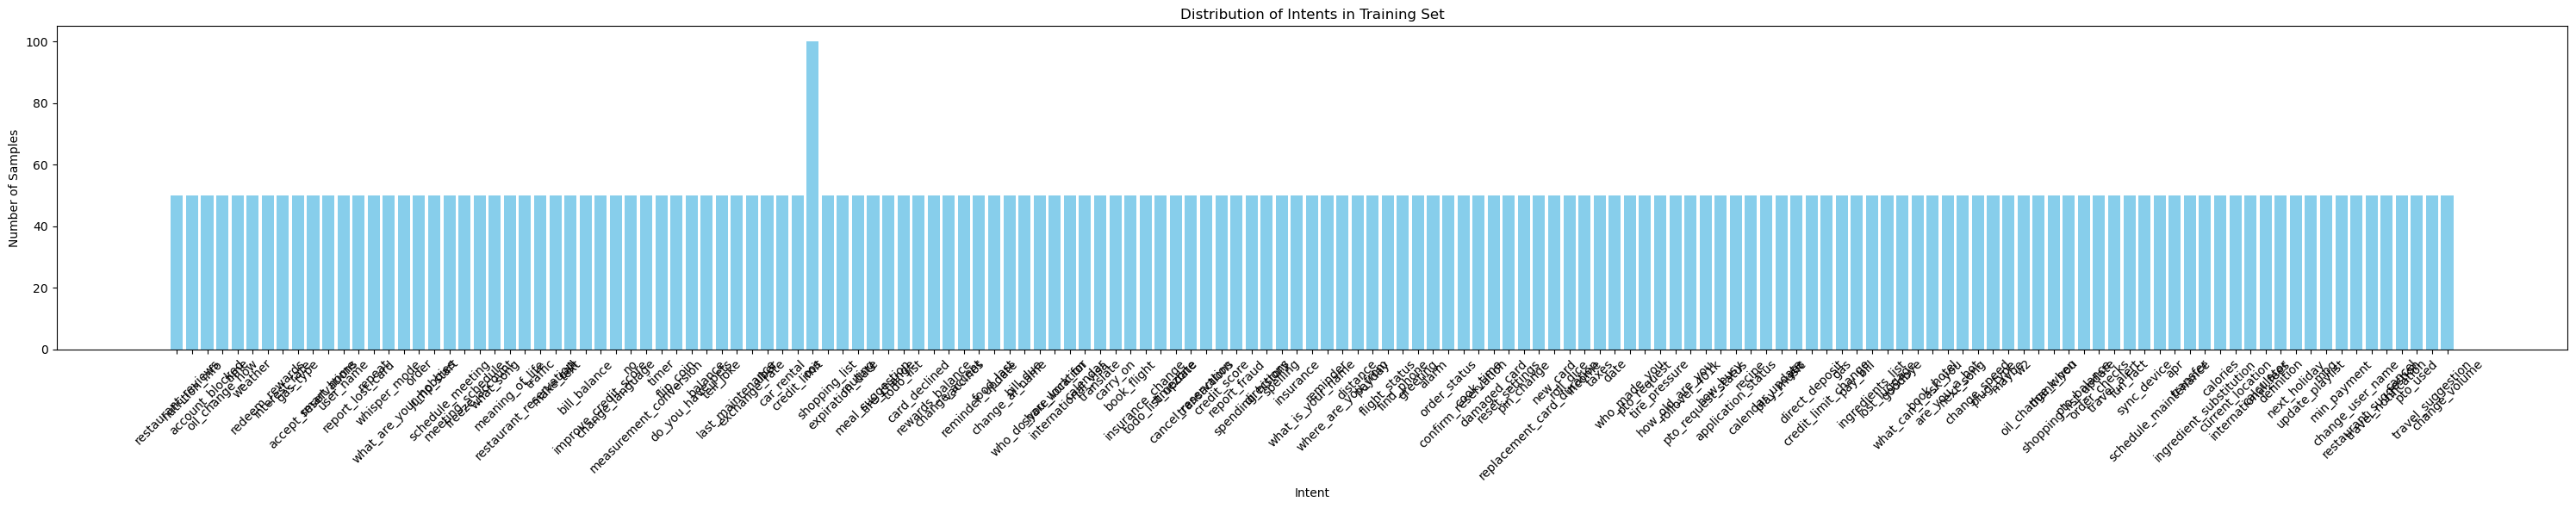

In [4]:
# a chart using matplotlib to show the distribution of intents in the training set
import matplotlib.pyplot as plt
import numpy as np  
intent_counts = np.bincount(train_labels)
intent_labels = [int2str(i) for i in range(len(intent_counts))] 
plt.figure(figsize=(30, 6))
plt.bar(intent_labels, intent_counts, color='skyblue')
plt.xlabel('Intent')
plt.ylabel('Number of Samples')
plt.title('Distribution of Intents in Training Set')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# **Step 2: Fine-tune BERT**

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer

NUM_CLASSES = dataset["train"].features["intent"].num_classes

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_CLASSES)

2025-07-08 21:33:04.935732: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 21:33:04.944945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751999584.956302   11434 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751999584.959828   11434 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751999584.968805   11434 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### **Step 2.1: Tekonize the data**

In [6]:
# tekonize the data
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)       

tokenized_datasets = dataset.map(tokenize_function, batched=True)


### **Step 2.2: Set format for PyTorch**


In [7]:
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "intent"])
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'intent', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7600
    })
    validation: Dataset({
        features: ['text', 'intent', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5500
    })
})

### **Step 2.3: Create DataLoaders**


In [8]:
from torch.utils.data import DataLoader
"""
DataLoaders are used to efficiently load batches of tokenized data for training and validation of the BERT model
---> train_loader provides batches of the training data to the model during training.
---> val_loader provides batches of the validation data to evaluate the model's performance during or after training.
"""
train_loader = DataLoader(tokenized_datasets["train"], batch_size=16, shuffle=True) 
val_loader = DataLoader(tokenized_datasets["validation"], batch_size=16)


### **Step 2.4: Train BERT (fine-tuning)**


In [9]:
# Tokenize and prepare dataset for Trainer
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

encoded_dataset = dataset.map(tokenize_function, batched=True)
encoded_dataset = encoded_dataset.rename_column("intent", "labels")
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Check a sample
encoded_dataset["train"][0]

{'labels': tensor(108),
 'input_ids': tensor([  101,  2064,  2017,  3328,  2033,  2083,  4292,  2039,  3622, 10042,
          2000,  2026,  2924,  1997,  4274, 10995,  4070,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,

In [21]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1}

# For older transformers versions, use eval_strategy instead of evaluation_strategy
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_dir="./logs",
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipykernel_11434/311998613.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.967664,0.842903,0.832499
2,3.454100,0.793594,0.919677,0.916521
3,1.118200,0.547787,0.931935,0.929519


TrainOutput(global_step=1425, training_loss=1.7426024105674343, metrics={'train_runtime': 140.7662, 'train_samples_per_second': 161.971, 'train_steps_per_second': 10.123, 'total_flos': 1501739374694400.0, 'train_loss': 1.7426024105674343, 'epoch': 3.0})

In [23]:
# evaluate the model using test dataset
test_results = trainer.evaluate(encoded_dataset["test"])
print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"Test F1 Score: {test_results['eval_f1']:.4f}")  



Test Accuracy: 0.8407
Test F1 Score: 0.8239


In [25]:
#save the model and tokenizer
model.save_pretrained("./intent_classifier_model")
tokenizer.save_pretrained("./intent_classifier_tokenizer")

('./intent_classifier_tokenizer/tokenizer_config.json',
 './intent_classifier_tokenizer/special_tokens_map.json',
 './intent_classifier_tokenizer/vocab.txt',
 './intent_classifier_tokenizer/added_tokens.json')

In [32]:
# load the model and tokenizer
from transformers import BertForSequenceClassification, BertTokenizer   
model = BertForSequenceClassification.from_pretrained("./intent_classifier_model")
tokenizer = BertTokenizer.from_pretrained("./intent_classifier_tokenizer")

# Example usage of the loaded model and tokenizer
text = "I want to take a fraud loan"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
outputs = model(**inputs)
predictions = outputs.logits.argmax(dim=-1)
predicted_intent = int2str(predictions.item())

if predicted_intent == "oos":
    print("The intent is out of scope (OOS).")
else:
    # preprocessing the predicted intent
    predicted_intent = predicted_intent.replace("_", " ").title()
    print(f"The predicted intent is: {predicted_intent}")

The predicted intent is: Report Fraud
